In [1]:
# Pipeline for preprocessing data for pca analysis
from preproc_tools import get_neuron_sample_test_fr, to_python_hdf5
import glob
import os
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm
from datetime import datetime
import json
from pathlib import Path
import h5py
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from ephysvibe.stats import smetrics
import matplotlib.pyplot as plt

In [2]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [3]:
def z_score(X,with_std=False):
    # X: ndarray, shape (n_features, n_samples)
    # X=X/ np.max(X,axis=1).reshape(-1,1)
    ss = StandardScaler(with_mean=True, with_std=with_std)
    Xz = ss.fit_transform(X.T).T
    return Xz,ss

In [4]:
def compute_pca(x, n_comp=50):
    model = PCA(n_components=n_comp)
    # C = model.components_
    # pc_s = C @ x
    pc_s = model.fit_transform(x.T).T
    return model, pc_s

In [5]:
def from_python_hdf5(load_path: Path):
    """Load data from a file in hdf5 format from Python."""
    with h5py.File(load_path, "r") as f:
        data = []
        for i_g in f.keys():
            group = f[i_g]
            dataset={}
            for key, value in zip(group.keys(), group.values()):
                dataset[key] = np.array(value)
            data.append(dataset)
    f.close()
    return data

In [2]:
import pickle

In [3]:
with open('./pfc_preprocdata.pickle', "br") as fp:
    data = pickle.load(fp)

In [10]:
data[-1]['fr']['0'].astype(np.float16)

array([[ 0.3552,  0.3726,  0.366 , ...,  0.2617,  0.2551,  0.255 ],
       [-0.544 , -0.5376, -0.528 , ...,  2.328 ,  2.29  ,  2.303 ],
       [-0.544 , -0.5376, -0.528 , ...,  0.2617,  0.2551,  0.255 ],
       ...,
       [-0.544 , -0.5376, -0.528 , ...,  0.2617,  0.2551,  0.255 ],
       [-0.544 , -0.5376, -0.528 , ..., -0.772 , -0.761 , -0.7686],
       [-0.544 , -0.5376, -0.528 , ..., -0.772 , -0.761 , -0.7686]],
      dtype=float16)

In [4]:
def compute_distance(data, rng, min_trials, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for asc in data:
        fr = asc["fr"]
        if fr is not None:
            meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
                scrum_neutralsize_samepool(fr, min_trials, rng)
            )
            s0mean.append(meanfr0)
            s11mean.append(meanfr11)
            s15mean.append(meanfr15)
            s51mean.append(meanfr51)
            s55mean.append(meanfr55)
            g1mean.append(g1)
            g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []
    for i in range(reshape_pc.shape[-1]):

        dist_n_nn.append(pdist(np.array((reshape_pc[:, 0, i], reshape_pc[:, 1, i]))))
        dist_fake_n_nn.append(pdist(np.array((fr_groups[:, 0, i], fr_groups[:, 1, i]))))

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


In [5]:
def scrum_neutralsize_samepool(fr, ntr, rng):

    nn = np.concatenate((fr["11"], fr["15"], fr["51"], fr["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(fr["0"].shape[0], size=ntr, replace=False)
    neutral_trs = fr["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [6]:
rng = np.random.default_rng(1997)

In [7]:
distance_data = Parallel(n_jobs=2)(
    delayed(compute_distance)(
        data, rng=rng, min_trials=25, select_n_neu=10
    )
    for _ in tqdm(range(2))
)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 20.19it/s]
c:\Users\camil\.virtualenvs\Users-zKW_FhGB\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [25]:
pp

{'dist_n_nn': array([3.2398245 , 3.24419821, 3.25562287, ..., 5.96904084, 6.00288522,
        5.97112547]),
 'dist_fake_n_nn': array([2.5183113 , 2.58926464, 2.54404286, ..., 2.72154805, 2.69206082,
        2.6548115 ]),
 'n_neurons': 1875}

In [11]:
res1 = {}
for area in ['lip','pfc','v4']:#'lip',
    res1[area]=from_python_hdf5('//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/all_neurons_in/2024-08-13_18-05-27/'+area+'_population_dist.h5')[0]

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '//envau_cifs.intlocal.univ-amu.fr/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population_lat/data/all_neurons_in/2024-08-13_18-05-27/pfc_population_dist.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [7]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

lip
34


KeyError: 'pfc'

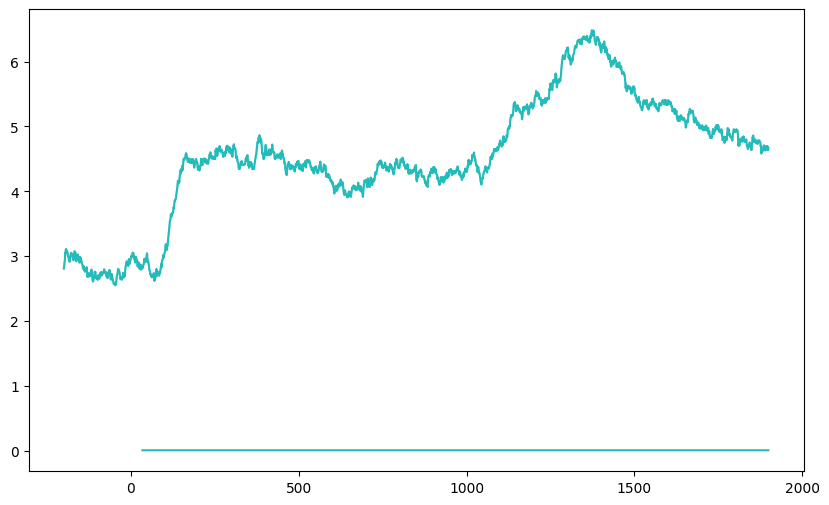

In [12]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','pfc','v4']):
    d=res1[area]['dist_n_nn'][:,:]
    fd=res1[area]['dist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])
    
    print(area)
    print(latency)
plt.legend(loc='upper left')
_=plt.title('25tr_1sp_Zscore_scrum_neutralsize_samepool')

lip
164
pfc
108


KeyError: 'v4'

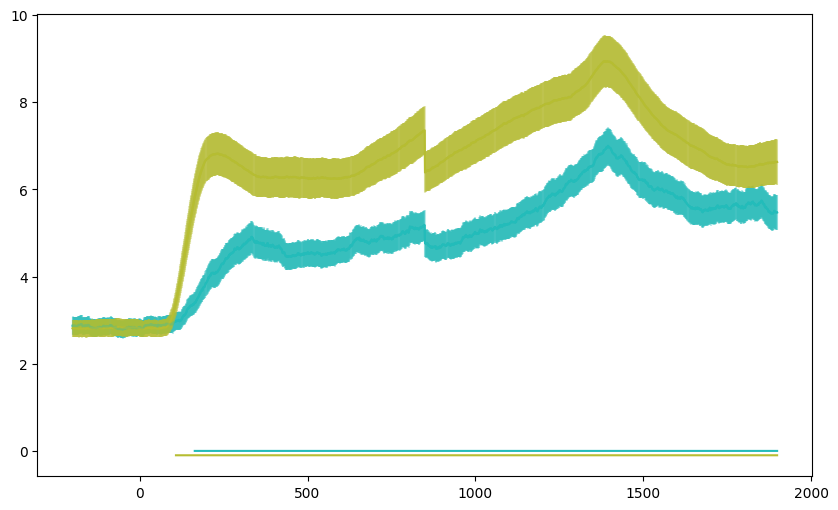

In [35]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip','pfc','v4']):
    d=res1[area]['all_dist_n_nn'][:,:]
    fd=res1[area]['alldist_fake_n_nn'][:,:]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res1[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])
    
    print(area)
    print(latency)
plt.legend(loc='upper left')
_=plt.title('25tr_1sp_Zscore_scrum_neutralsize_samepool')

lip
106
lip
96


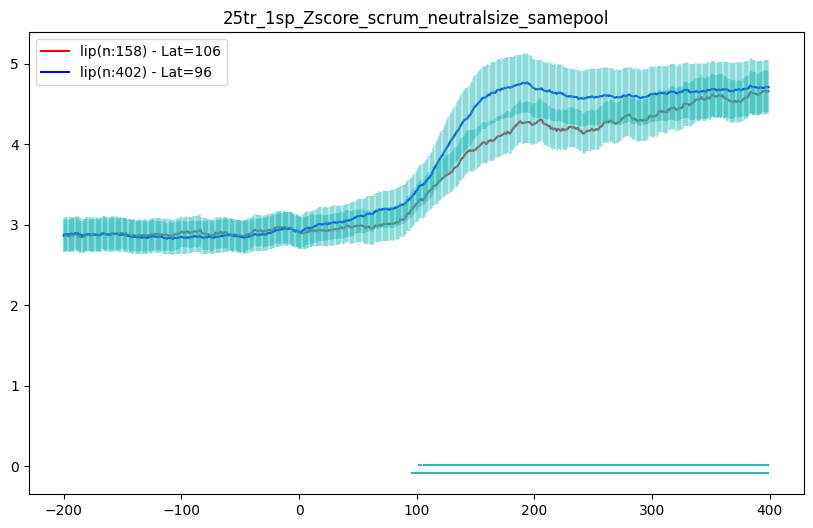

In [32]:
_=plt.figure(figsize=(10,6))
area='lip'
col=['r','b']
for ia,resarea in enumerate([res1,res2]):
    d=resarea[area]['all_dist_n_nn'][:,:600]
    fd=resarea[area]['alldist_fake_n_nn'][:,:600]

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    latency=latency-200
    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=col[ia],label=area+'(n:'+str(resarea[area]['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])
    
    print(area)
    print(latency)
plt.legend(loc='upper left')
_=plt.title('25tr_1sp_Zscore_scrum_neutralsize_samepool')